# Preambule

## libraries

In [1]:
library(tidyverse)
library(stringr)
library(caret)
library(data.table)
library(stringr)
library(dplyr)
library(qs)
library(parallel)
library(randomForest)
library(inTrees)
library(endoR)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


qs v0.23.4.

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package

In [2]:
library(parallel)

In [3]:
library(viridis)

Loading required package: viridisLite



In [4]:
library(ggpubr)

In [5]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.4.0        viridis_0.5.1       viridisLite_0.3.0  
 [4] endoR_0.1.0         inTrees_1.3         randomForest_4.6-14
 [7] qs_0.23.4           data.table_1.13.4   caret_6.0-86       
[10] lattice_0.20-41     forcats_0.5.0       stringr_1.4.0    

## functions

In [6]:
getSinglePR <- function(pc, expanded_edges, all){
    # prepare edges from endoR
    edges <- pc$edges_agg %>% select(x, y, condition, importance, influence, d.x, d.y) %>% 
        subset(condition %in% pc$rules_summary$condition) %>%
        group_by(x, y, condition) %>% 
        summarise(importance= mean(importance), influence = mean(influence*(d.x+d.y)/2)) %>%
        ungroup %>% 
        left_join(select(pc$rules_summary,condition, inN, imp, n), by = 'condition') %>% 
        select(-condition) 
    
    # get the PR
    edi <- lapply(unique(edges$inN)
            , function(i, edges, true_edges,expanded_edges, all){
                suppressMessages(edges <- edges %>% subset(inN >= i) %>% group_by(x, y) %>% 
                                 summarise( inN = max(inN), importance = sum(importance*imp*n)
                                           , influence = sum(influence*imp*n)/sum(imp*n) ) %>% ungroup)
                metricsNet(edges = edges,expanded_edges=expanded_edges, all=all)
              }, edges=edges,expanded_edges=expanded_edges, all=all)
    
    edi <- as.data.frame(do.call(rbind, edi))
    edi$inN <- unique(edges$inN)
    edi <- add_row(edi, n_edges=0, tp=0,fp=0,tn=0,fn=0,inN=0)
    
    return(edi %>% arrange(tp))
}

In [7]:
getPR <- function(f, alpha, pi_thr, related_taxa, all){
    res <- qread(f)
    # get the true edges
    te <- lapply(res$true_edges, str_replace_all, pattern = '\\_{2}.*', replacement = '')
    te <- unique(lapply(te, sort))
    expanded_edges <- list()
    for (i in 1:length(te)){
        tmp <- te[[i]] %>% str_replace(pattern = '\\_{2}.*', replacement = '')
        tmp <- related_taxa[tmp]
        tmp <- expand.grid(tmp[[1]], tmp[[2]])  
        tmp <- asplit(tmp, MARGIN=1)

        expanded_edges[[i]] <- sapply(lapply(tmp, sort), paste, collapse = ' - ')
        names(expanded_edges)[i] <- paste(sort(te[[i]]), collapse = ' - ')
    }
    # other parameters
    seedN <- str_extract(f, pattern = '(?<=simu)[:digit:]+(?=\\_)')
    K <- length(expanded_edges)
    
    # for b = 10
    set.seed(as.numeric(seedN))
    i_10 <- sample(1:100, 10, replace = FALSE)
    pc10 <- stabilitySelection(res$resamp[i_10], alpha_error = alpha, pi_thr = pi_thr)
    edi10 <- getSinglePR(pc10, expanded_edges, all = all)
    edi10$B <- length(i_10)
    
    # for b = 90
    pc100 <- quiet(stabilitySelection(res$resamp[-i_10], alpha_error = alpha, pi_thr = pi_thr))
    edi100 <- getSinglePR(pc100, expanded_edges, all = all)
    edi100$B <- 100-length(i_10)
    
    # bind
    edi <- rbind(edi10, edi100)
    edi$seedN <- seedN
    edi$K <- K
    
    return(edi)
}

In [8]:
file.sources <- list.files('../scripts/', pattern = '*.R', full.names=TRUE, ignore.case=TRUE)
for (f in file.sources) {
    source(f)
}
rm('file.sources', 'f')

# Run

In [9]:
fnames <- list.files('/ebio/abt3_projects/temp_data/aruaud/MtgSimu50/', full.names = TRUE, recursive = TRUE
                    )%>% str_subset(pattern = 'B100/')

In [10]:
related_taxa <- qread('../tmp/related_taxa_full.qs')
is_s <- str_which(names(related_taxa), pattern = '^s_')
related_taxa[is_s] <- related_taxa[is_s] %>% lapply(function(x){str_subset(x, pattern = '^s|g')})
related_taxa$groupa <- 'groupa'
related_taxa$groupb <- 'groupb'
related_taxa$groupc <- 'groupc'
related_taxa$groupd <- 'groupd'

In [11]:
#stopCluster(cluster)
cluster <- makeCluster(7)
quiet(clusterEvalQ(cluster, library(qs)))
quiet(clusterEvalQ(cluster, library(endoR)))
quiet(clusterEvalQ(cluster, library(tidyverse)))
quiet(clusterExport(cluster, c('getSinglePR', 'metricsNet', 'quiet' )))

In [12]:
a10_sev <- parLapply(cl = cluster, fnames, getPR, alpha = 10, pi_thr = 0.7, related_taxa=related_taxa
                     , all = (525^2-525)/2)
a10_sev <- do.call(rbind, a10_sev)

In [13]:
stopCluster(cluster)

In [14]:
a10_sev %>% summary

    n_edges             tp              fp               tn        
 Min.   :  0.00   Min.   :0.000   Min.   :  0.00   Min.   :     0  
 1st Qu.: 34.00   1st Qu.:3.000   1st Qu.: 27.00   1st Qu.:137475  
 Median : 54.00   Median :5.000   Median : 43.00   Median :137496  
 Mean   : 61.79   Mean   :4.957   Mean   : 48.75   Mean   :134193  
 3rd Qu.: 81.00   3rd Qu.:7.000   3rd Qu.: 63.00   3rd Qu.:137511  
 Max.   :427.00   Max.   :9.000   Max.   :301.00   Max.   :137542  
       fn             inN              B            seedN          
 Min.   :0.000   Min.   : 0.00   Min.   :10.00   Length:4169       
 1st Qu.:2.000   1st Qu.:10.00   1st Qu.:90.00   Class :character  
 Median :4.000   Median :31.00   Median :90.00   Mode  :character  
 Mean   :4.323   Mean   :34.97   Mean   :79.47                     
 3rd Qu.:6.000   3rd Qu.:55.00   3rd Qu.:90.00                     
 Max.   :9.000   Max.   :90.00   Max.   :90.00                     
       K        
 Min.   :7.000  
 1st Qu.:9.000

In [15]:
av_a10 <- a10_sev %>% select(-seedN) %>% group_by(B, inN) %>% summarise_all(mean)

# interpolate

In [16]:
getInterpo <- function(i, raw){
    raw <- subset(raw, seedN == i)
    res <- list()
    
    N <- unique(raw$Ncol)
    N <- (N^2-N)/2
    K <- unique(raw$K)
    
    i <- 1
    for (a in unique(raw$B)){
        tmp <- approx(raw$fp[raw$B == a]
                       , raw$tp[raw$B == a]
                       , xout = seq(1, 144, length.out = 1000)
                       , ties = max)
        tmp <- as.data.frame(do.call(cbind, tmp))
        colnames(tmp) <- c('fp', 'tp')
        
        # add 0 and max values to the extrapolations
        #mifp <- min(tmp$fp[!is.na(tmp$tp)])
        mafp <- max(tmp$fp[!is.na(tmp$tp)])
        #tmp$tp[tmp$fp<mifp] <- min(tmp$tp)
        tmp$tp[tmp$fp>mafp] <- max(tmp$tp, na.rm = TRUE) #K
        
        tmp <- tmp[complete.cases(tmp),]
        #tmp <- tmp %>% add_row(tp = 0, fp = 0)
        tmp$B <- a

        res[[i]] <- tmp
        i <- i+1
    }
    res <- do.call(rbind, res)
    res$seedN <- i
    
    return(res)
}

In [17]:
a10_byseed <- suppressWarnings(lapply(unique(a10_sev$seedN), getInterpo, raw = a10_sev))

In [18]:
a10_byseed_av <- do.call(rbind, a10_byseed) %>% select(-seedN) %>% group_by(fp, B) %>% summarise_all(mean)
a10_byseed_sd <- do.call(rbind, a10_byseed) %>% select(-seedN) %>% group_by(fp, B) %>% summarise_all(sd)

a10_forplots <- left_join(a10_byseed_av, a10_byseed_sd, by = c('fp', 'B'), suffix = c('_av', '_sd'))

# random

In [30]:
random_pr_curve <- function(K){
  N <- (525^2-525)/2 
    
  urn <- c(rep(1, K), rep(0, N-K))
  B <- 1000
  res <- list()
    
  for(j in 1:B){
    set.seed(j)
    random_draw <- urn[sample(1:N)]
    tp <- cumsum(random_draw)
    fp <- 1:N - cumsum(random_draw)
    linfit <- approx(fp, tp, xout = seq(1, 150, length.out = 1000),ties = max)
      
    tmp <- as.data.frame(do.call(cbind, linfit))
    colnames(tmp)<- c('fp', 'tp')
    # add 0 and max values to the extrapolations
    mifp <- min(tmp$fp[!is.na(tmp$tp)])
    mafp <- max(tmp$fp[!is.na(tmp$tp)])
    tmp$tp[tmp$fp<mifp] <- min(tmp$tp)
    tmp$tp[tmp$fp>mafp] <- K  
    res[[j]] <- tmp[ complete.cases(tmp), ]
  }
 
  res <- do.call(rbind, res)
  res <- res %>% group_by(fp) %>% summarise(tp = mean(tp), qtiles = quantile(tp, 0.99))
  
  return(res)
  
}

In [33]:
#stopCluster(cluster)
cluster <- makeCluster(5)
clusterEvalQ(cluster, library(qs))
clusterEvalQ(cluster, library(tidyverse))
clusterExport(cluster, c('random_pr_curve'))

[[1]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[3]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[4]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[5]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"

[[1]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "qs"        "stats"     "graphics" 
[13] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "qs"        "stats"     "graphics" 
[13] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "qs"        "stats"     "graphics" 
[13] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "qs"        "stats"     "graphics" 
[13] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[5]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "qs"        "stats"     "graphics" 
[13] "grDevices" "utils"     "datasets"  "methods"   "base"

In [32]:
Ks <- a10_sev %>% select(K, seedN) %>% unique %>% select(K) %>% unlist

In [34]:
rdm <- parLapply(cluster, Ks,random_pr_curve)

In [35]:
stopCluster(cluster)

In [36]:
rdm_av <- do.call(rbind, rdm ) %>% group_by(fp) %>% summarise_all(mean)
rdm_sd <- do.call(rbind, rdm) %>% group_by(fp) %>% summarise_all(sd)
rdm_av <- left_join(rdm_av, rdm_sd, by = c('fp'), suffix = c('_av', '_sd'))

In [37]:
saveRDS(rdm_av, './tmp/sevB_rdm.RDS')

In [20]:
rdm_av <- readRDS('../tmp/sevB_rdm.RDS')

# plots

In [21]:
av_a10$B <- factor(av_a10$B, levels = c('10', '90'))
a10_forplots$B <- factor(a10_forplots$B, levels = c('10', '90'))

In [22]:
cols <- plasma(length(unique(a10_sev$B)) + 2)

In [23]:
p <- ggplot(a10_forplots %>% subset(fp < 100)
             , aes(x = fp, y = tp_av, group = B, color = as.factor(B)))+

geom_hline(yintercept = 9, color = 'lightgrey', linetype = 'dashed')+

geom_line(data = rdm_av %>% subset(fp < 100), aes(y = tp_av, x = fp), group=NA, color = 'darkgrey')+
geom_ribbon(data = rdm_av %>% subset(fp < 100)
            , aes(ymin = tp_av - tp_sd/2, ymax = tp_av + tp_sd/2, y = tp_av
                  , group=NULL, color = NULL)
            , alpha = 0.4, fill = 'darkgrey') +

geom_line(size = 1)+

geom_ribbon(aes(ymin = tp_av - tp_sd/2, ymax = tp_av + tp_sd/2
                , group = B, fill = as.factor(B)), color = NA
            , alpha = 0.25) +


geom_point(data = av_a10 %>% subset((B == '10' & inN == 7) | (B == '90' & inN == 63))
           , aes(y = tp, x = fp, fill = as.factor(B))
           , size = 4, shape = 21, color = 'black')+


theme_classic()+
labs(x = 'Number of FP', y = 'Number of TP') +
scale_color_manual(values = cols[-c(1, length(cols))], name = 'B') +
scale_fill_manual(values = cols[-c(1, length(cols))], name = 'B')


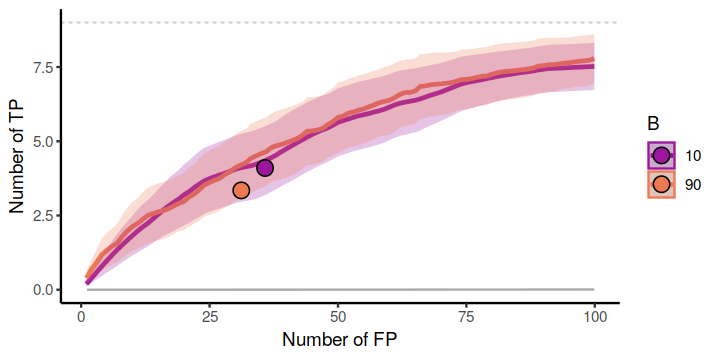

In [24]:
options(repr.plot.width=6, repr.plot.height=3)
p

# check

In [39]:
bootRes <- function(pc, B, expanded_edges, pre_res){
    cond <- pc$rules_summary %>% subset(inN >= .7*B, select = condition) %>% unlist
    if (length(cond) > 0){
            
        imp_edges <- pc$edges_agg %>% subset(condition %in% cond) %>% select(x,y, importance, n, imp)
        imp_edges$x <- str_replace(imp_edges$x, pattern = '\\_{2}.*', replacement = '')
        imp_edges$y <- str_replace(imp_edges$y, pattern = '\\_{2}.*', replacement = '')
        suppressMessages(imp_edges <- imp_edges %>% group_by(x,y) %>% summarise(importance = sum(n*imp*importance)))
        imp_edges <- asplit(as.matrix(imp_edges), MARGIN = 1)
        imp_edges <- lapply(imp_edges, sort) 
        pred_edges <- sapply(imp_edges, function(x){paste(x[-1], collapse = ' - ')}) 
        imp_edges <- sapply(imp_edges, function(x)x['importance']) 

        # those that should not be but are = in pred_edges but not truth
        fp <- sum(sapply(pred_edges, function(x){!(x %in% unlist(expanded_edges))}))
        tp <- sum(sapply(expanded_edges, function(x){ifelse(sum(x %in% pred_edges) > 0, 1, 0)}))
        fn <- sum(sapply(names(expanded_edges), function(x){!(x %in% pred_edges)}))


        # sum of FP importances
        if(fp > 0) {
            fp_imp <- which(sapply(pred_edges, function(x){!(x %in% unlist(expanded_edges))}))
            fp_imp <- sum(as.numeric(imp_edges[fp_imp]))
        } else {fp_imp <- 0}
        # sum of TP importances
        if(tp > 0) {
            tp_imp <- list()
            for (i in 1:length(expanded_edges)){
                tp_imp[[i]] <- mean(as.numeric(imp_edges[which(pred_edges %in% expanded_edges[[i]])]))
            }
            tp_imp <- sum(unlist(tp_imp), na.rm = TRUE)
        } else {tp_imp <- 0}

        res <- c('B' = B, 'rf_accuracy' = pre_res$gamma_all[1, 'meanK'], 'n_decisions' = length(cond)
                , 'tp_imp' = tp_imp, 'fp_imp' = fp_imp, 'tp' = tp, 'fp' = fp
                , 'fn' = fn)
    } else {
        res <- c('B' = B, 'rf_accuracy' = pre_res$gamma_all[1, 'meanK'], 'n_decisions' = 0
                , 'tp_imp' = 0, 'fp_imp' = 0, 'tp' = 0, 'fp' = 0, 'fn' = 0)
    }
}    

In [40]:
getRes <- function(f, p = NULL, related_taxa){
    pre_res <- qread(f)
    seedN <- str_extract(f, pattern = '(?<=simu)[:digit:]+(?=\\_)')
    
    # get the true edges
    te <- lapply(pre_res$true_edges, str_replace_all, pattern = '\\_{2}.*', replacement = '')
    te <- unique(lapply(te, sort))
    expanded_edges <- list()
    for (i in 1:length(te)){
        tmp <- te[[i]] %>% str_replace(pattern = '\\_{2}.*', replacement = '')
        tmp <- related_taxa[tmp]
        tmp <- expand.grid(tmp[[1]], tmp[[2]])  
        tmp <- asplit(tmp, MARGIN=1)

        expanded_edges[[i]] <- sapply(lapply(tmp, sort), paste, collapse = ' - ')
        names(expanded_edges)[i] <- paste(sort(te[[i]]), collapse = ' - ')
    }
        
    # get the new metrics
    
    # B = 10
    set.seed(as.numeric(seedN))
    i_10 <- sample(1:100, 10, replace = FALSE)
    quiet(pc <- stabilitySelection(pre_res$resampled[i_10], alpha_error = 10, pi_thr = 0.7))
    res10 <- bootRes(pc, B = 10, expanded_edges=expanded_edges, pre_res=pre_res)
    
    # B = 90
    quiet(pc <- stabilitySelection(pre_res$resampled[-i_10], alpha_error = 10, pi_thr = 0.7))
    res90 <- bootRes(pc, B = 90, expanded_edges=expanded_edges, pre_res=pre_res)
    
    
    return(rbind(res10, res90))
}

In [41]:
check <- lapply(fnames, getRes, related_taxa = related_taxa)
check <- as.data.frame(do.call(what = rbind, check))

In [42]:
check$precision <- check$tp/(check$tp+check$fp)
check$recall <- check$tp/(check$tp+check$fn)
check$w_precision <- check$tp_imp/(check$tp_imp+check$fp_imp)

In [43]:
check %>% group_by(B) %>% summarise_all(mean, na.rm = TRUE) %>% #subset(N != 1000) %>% 
select(B, rf_accuracy, n_decisions, tp, fp, fn, tp_imp, fp_imp, precision, recall, w_precision) 

B,rf_accuracy,n_decisions,tp,fp,fn,tp_imp,fp_imp,precision,recall,w_precision
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,0.8943911,36.0,4.10,35.80,5.48,69.02939,18.48926,0.1166578,0.4260606,0.6255404
90,0.8943911,26.9,3.52,28.48,6.08,591.27896,141.18844,0.1256255,0.3663283,0.6362664


In [44]:
check %>% group_by(B) %>% summarise_all(sd, na.rm = TRUE) %>% #subset(N != 1000) %>% 
select(B, rf_accuracy, n_decisions, tp, fp, fn, tp_imp, fp_imp, precision, recall, w_precision) 

B,rf_accuracy,n_decisions,tp,fp,fn,tp_imp,fp_imp,precision,recall,w_precision
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,0.03108126,10.79304,1.876275,12.02548,1.798412,69.69825,13.5689,0.07211268,0.1903263,0.3122550
90,0.03108126,10.42221,1.728985,10.20452,1.770968,572.79811,105.0933,0.07961275,0.1843138,0.3290701


In [45]:
check %>% count(B)

B,n
<dbl>,<int>
10,50
90,50
